# Step 1: Gather Exchanges & Stock Symbols

Using the finnhub API, we gather the list of exchanges and stocks to be used for further analysis. This section is limited by:

1) Manually searching the list of exchanges

2) Limited call count (30 calls/sec on free plan)

In [1]:
from find_news import retrieve_articles, save_data
from stock_retrieval import retrieve_exchanges_and_stock
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
news_api_key = os.getenv('NEWS_API_KEY')
finn_api_key = os.getenv('FINNHUB_KEY')

In [2]:
#We have a list of exchanges(hard-coded), a list of stocks per exchange
exchanges = "AS,AT,AX,BA,BC,BD,BE,BK,BO,BR,CA,CN,CO,CR,DB,DE,DU,F,HE,HK,HM,IC,IR,IS,JK,JO,KL,KQ,KS,L,LN,LS,MC,ME,MI,MU,MX,NE,NL,NS,NZ,OL,PA,PM,PR,QA,RG,SA,SG,SI,SN,SR,SS,ST,SW,SZ,T,TA,TL,TO,TW,TWO,US,V,VI,VN,VS,WA,HA,SX,TG,SC"
exchanges = exchanges.split(",")
exchange_stock_dict= retrieve_exchanges_and_stock(exchanges,finn_api_key,True)

Beginning Stock Exchange/Stock Retrieval...
Collected finnhub api-key
Beginning stock information collection
Delaying calls by  41.96795320510864
Resuming calls
Returning list of exchanges and exchange_data...


In [3]:
#Verify the correctness of the stock_dict:
print(len(exchange_stock_dict["US"]))
print(type(exchange_stock_dict["US"]))

28794
<class 'list'>


# Step 2: Gather news on a particular stock

Using the newly acquired dataset of stocks for every exchange in the world, we can find news articles on a particular stock using the "News" API. With the News API, we will receive data such as the title, author, and description of the article. In addition, we can sort our search results by popularity (which we do). Some limitations of this section include:

1) Restricted call count (Free plan ==> 100calls/day)

2) Restricted article dates (Free plan ==> can only search articles from 30 days ago MAX)

3) Articles are sometimes unrelated to stock (attempted to resolve by using different keyword `symbol+"stock"`, where `symbol` is a stock symbol. 

In [4]:
days_ago = 30
#print(len(stock_data)) #Index is equal to exchanges
#print(len(stock_data[0])) #Index is stocks in specific exchange
#print(exchange_dict["US"])#Use dict to find specific index

us_stock = exchange_stock_dict["US"]
article_data = []
us_stock_article = {}

for stock in us_stock:
    #print(stock["symbol"])
    status, article = retrieve_articles(stock["symbol"]+" stock",
                                        days_ago,news_api_key, True)
    if(status == "error"):
        if(article == "rateLimited"):
            print("Reached rate limit")
            break
    elif(article["totalResults"] >0):#Assuming each stock symbol is unique
        us_stock_article[stock["symbol"]] = article
        



Error: rateLimited
You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.
Reached rate limit


In [5]:
"""
Test the data
"""
print(len(us_stock_article))

0


# Step 3: Save the data

Since the data we retrieve from the NEWS API is limited, we should save the data we gather. We encode the data into a json file marked as `results.json`

In [6]:
"""
Write the data into a JSON file (to permanently store data)

1) We will use this data to test the accuracy 
of our sentiment analysis
"""
#Comment out when not needed
#save_data('results.json', dict_data)

'\nWrite the data into a JSON file (to permanently store data)\n\n1) We will use this data to test the accuracy \nof our sentiment analysis\n'

# Step 3: Sentiment Analysis

Now we want to determine how positive these articles are about a stock. We can do so by using "Pre-trained sentiment analysis models" which are robust models that allow us to classify the positivity/negativity/neutrality of a statement. Given a stock symbol with n articles, we return 

1) The positivity/negativity/neutrality of each article **title**

2) The positivity/negativity/neutrality of each article **description**


And we repeat this for every stock symbol that we were able to search and find articles for. We sum each of these scores together and divide it by `totalResults`$*2$ to yield our **average sentiment** on a stock

In [37]:
"""
Read the Data
"""
import pandas as pd 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sentiment_analyzer import sentiment_scoring
import seaborn as sns
#plt.style.use('ggplot')

test_data = pd.read_json('results.json')
print(test_data["QTUM"]["articles"])

[{'source': {'id': None, 'name': 'TheStreet'}, 'author': 'David Dierking', 'title': "5 Disruptive Tech ETFs That Aren't ARKK - TheStreet", 'description': "You may want to abandon Cathie Wood's funds, but don't abandon disruptive tech altogether.", 'url': 'https://www.thestreet.com/etffocus/blog/5-disruptive-tech-etfs-that-arent-arkk', 'urlToImage': 'https://www.thestreet.com/.image/t_share/MTkwMDMzNzI5Nzk4ODA5MzQy/etf-focus-report-master---sector-technicals-report-2-page-001-3.jpg', 'publishedAt': '2022-06-07T15:35:13Z', 'content': 'If there is a “rock star” in the ETF industry, it’s probably Cathie Wood. Love her or hate her, she has undeniably become not only one of the faces of the ETF space, but the poster child for disrupti… [+8012 chars]'}]


In [8]:
#Roberta Pretrained Model

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In this section, we focus on collecting the sentiment on a stock from individual, related articles. We then sum these scores and average them to get our *final score* on a given stock. 

In [19]:
avg_sentiment = {} #Aggregate sentiment of stock
for stock in test_data:
    pos = 0
    neg = 0
    neu = 0
    for article in test_data[stock]["articles"]:
        title_score = sentiment_scoring(str(article["title"]), model, tokenizer)
        description_score = sentiment_scoring(str(article["description"]), model, tokenizer)
        
        neg += title_score['neg']+description_score['neg']
        pos += title_score['pos']+description_score['pos']
        neu += title_score['neu']+description_score['neu']
    
    avg_neg = neg/int(test_data[stock]["totalResults"])/2.0
    avg_pos = pos/int(test_data[stock]["totalResults"])/2.0
    avg_neu = neu/int(test_data[stock]["totalResults"])/2.0
    
    avg_sentiment[stock] = {
        "neg":avg_neg,
        "pos":avg_pos,
        "neu":avg_neu,
    }

# Results

We finally have our results! The data listed below is a sentiment on articles written about stocks from `days_ago` days ago, which is a variable listed earlier in this document. To assess the popularity or unpopularity of stocks, we list and plot the scores below:

In [70]:
stock_sentiment = pd.DataFrame(avg_sentiment).T
stock_sentiment["stocks"] = stock_sentiment.index
#print("Average Scoring per stock:\n",stock_sentiment)
print("\nMost positive Stocks:\n", stock_sentiment.sort_values('pos', ascending = False))
print("\nMost Neutral Stock:\n", stock_sentiment.sort_values('neu', ascending = False))
print("\nMost Negative Stock:\n", stock_sentiment.sort_values('neg', ascending = False))


Most positive Stocks:
             neg       pos       neu stocks
GRX    0.002050  0.882919  0.115031    GRX
HASI   0.009843  0.491402  0.498755   HASI
ENGIY  0.039082  0.450427  0.510491  ENGIY
SNN    0.275413  0.410325  0.314262    SNN
FUTU   0.105893  0.333378  0.560728   FUTU
ASTR   0.233088  0.332096  0.434816   ASTR
KHRNF  0.015681  0.308448  0.675871  KHRNF
EMR    0.079446  0.289216  0.631338    EMR
MTH    0.193230  0.266409  0.540361    MTH
JAVA   0.113498  0.253508  0.632994   JAVA
FSLY   0.103035  0.246810  0.650155   FSLY
SUZ    0.171514  0.243375  0.585111    SUZ
CUBS   0.184420  0.238099  0.577481   CUBS
ZAHA   0.092863  0.139863  0.767274   ZAHA
CHB    0.062076  0.139776  0.798148    CHB
UNAM   0.213898  0.138549  0.647553   UNAM
APLT   0.023623  0.112625  0.863752   APLT
TANH   0.101994  0.085156  0.812850   TANH
DUNE   0.066273  0.084970  0.533688   DUNE
QTUM   0.265604  0.048092  0.686305   QTUM
PORT   0.017526  0.042942  0.054607   PORT
EWH    0.331062  0.035112  0.6

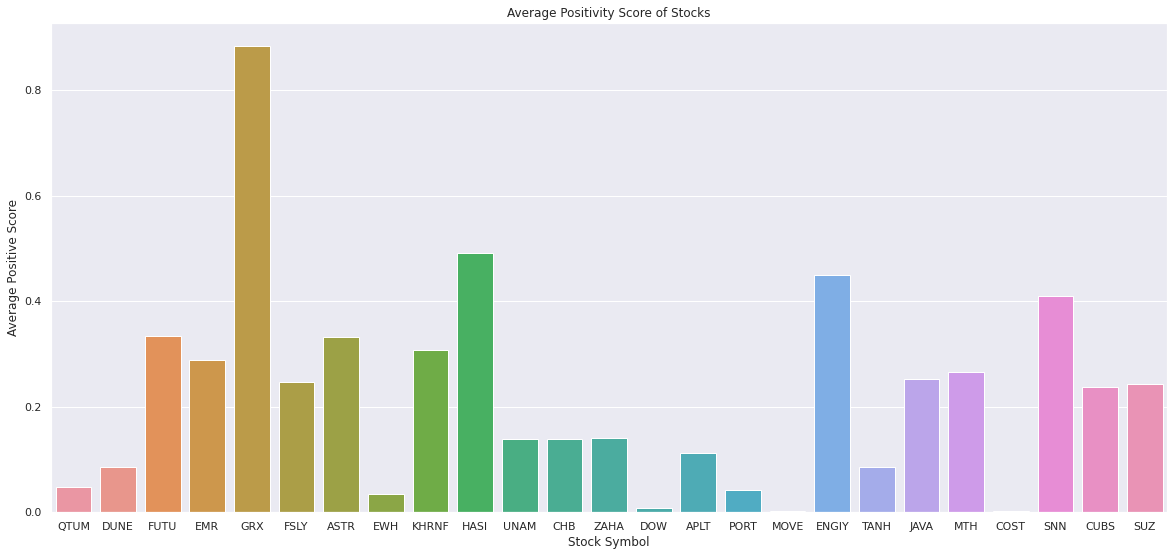

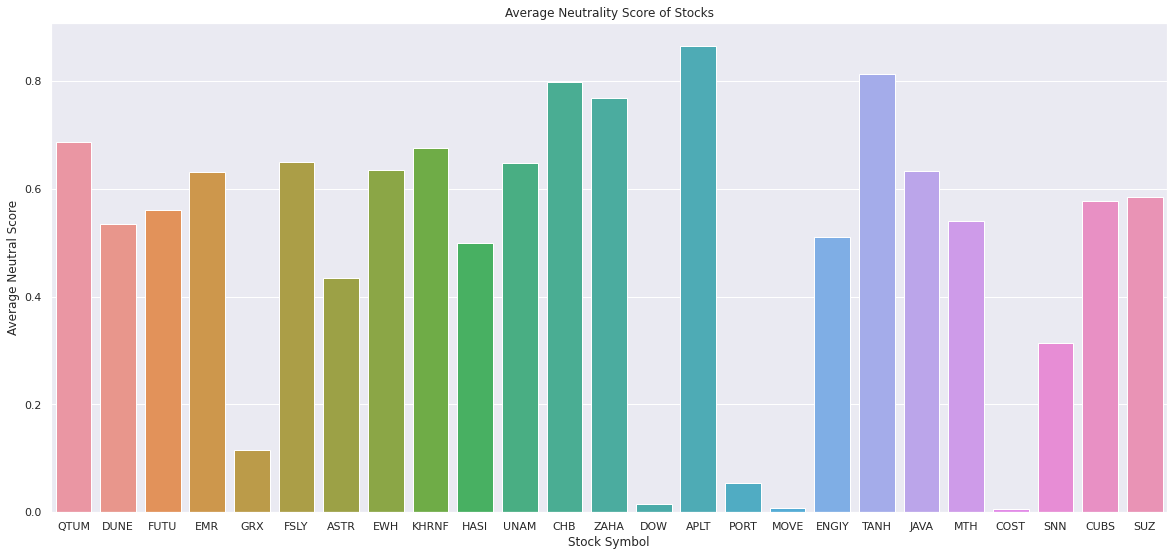

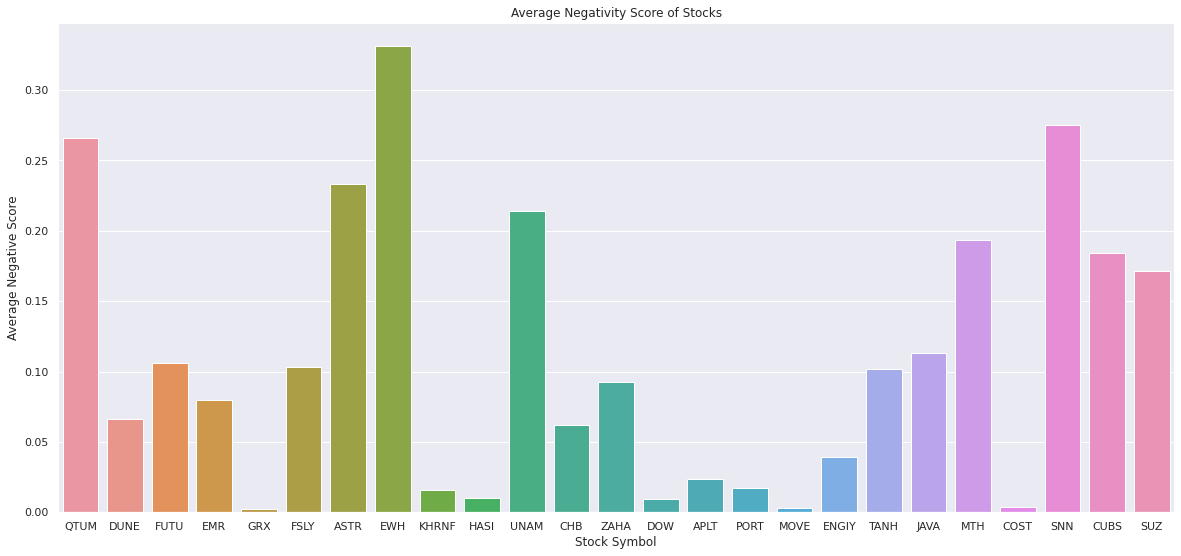

In [72]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.barplot(x='stocks', y='pos',
            data=stock_sentiment)
ax.set(xlabel='Stock Symbol', ylabel='Average Positive Score', title = "Average Positivity Score of Stocks")

plt.show()

ax = sns.barplot(x='stocks', y='neu',
            data=stock_sentiment)
ax.set(xlabel='Stock Symbol', ylabel='Average Neutral Score', title = "Average Neutrality Score of Stocks")

plt.show()

ax = sns.barplot(x='stocks', y='neg',
            data=stock_sentiment)
ax.set(xlabel='Stock Symbol', ylabel='Average Negative Score', title = "Average Negativity Score of Stocks")


plt.show()